In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle
import matplotlib.pyplot as plt

## Importar modelo/s

In [2]:
with open('models/model_enfermeras.pkl','rb') as f:
    modelo_enfermeria_arima=pickle.load(f)

In [3]:
with open('models/model_enfermeras_plantilla.pkl','rb') as f:
    modelo_plantilla_profet=pickle.load(f)

In [4]:
with open('models/model_enfermeras_google.pkl','rb') as f:
    modelo_google_arima=pickle.load(f)

In [5]:
#Importamos dataset
df = pd.read_csv('output/Enfer.csv', sep=',',encoding='latin1',decimal=".")
ts=df.set_index('date').drop(['index','COLECTIVO','mes','año','casos_covid'],axis=1)

In [6]:
ts

,Festivos_intersemanales,Plantilla,Plantilla_de_baja,busquedas_google,cambio_normativa
date,,,,,
2003-01-01,2,861.654839,58.322581,18.896169,0
2003-02-01,1,847.775357,63.000000,29.335714,0
2003-03-01,0,857.704194,69.477419,18.494624,0
2003-04-01,2,869.806667,70.153333,16.111111,0
2003-05-01,1,855.794839,61.032258,16.741935,0
...,...,...,...,...,...
2021-10-01,1,1417.836129,65.073548,63.625000,0
2021-11-01,1,1412.164000,65.600333,73.666667,0
2021-12-01,2,1411.344516,92.730645,69.548387,0


## Predicción valores exógenos

### Predicción plantilla

In [7]:

ds= pd.DataFrame({'ds':pd.date_range(start='2022-03-01',
                                  end='2022-12-01',
                                  freq='MS')})
yhat=modelo_plantilla_profet.predict(ds).yhat
exogenos=pd.DataFrame(data=yhat.to_numpy(),index=ds['ds'],columns=['Plantilla'])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Predicción búsquedas google

In [8]:
histórico_google=ts[['busquedas_google']][32:] #desde septiembre de 2005

In [9]:
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = modelo_google_arima.order 
sparams = modelo_google_arima.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodelo_google_arima = SARIMAX(histórico_google, 
                order=params,
                seasonal_order=sparams, 
                freq='MS'
                )
results_google=smodelo_google_arima.fit(maxiter=100)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [10]:
y_pred_google=results_google.get_prediction(start='2022-03-01',end='2022-12-01').predicted_mean

In [11]:
exogenos['busquedas_google']=y_pred_google.to_numpy()

In [12]:
#exogeno_google=pd.DataFrame(data=y_pred_google.to_numpy(),index=ds['ds'],columns=['busquedas_google'])

### Festivos_intersemanales

In [13]:
festivos_intersemanales=[0,2,1,2,0,1,0,1,1,3]

In [14]:
exogenos['Festivos_intersemanales']=np.array(festivos_intersemanales)
#exogeno_fi=pd.DataFrame(data=np.array(festivos_intersemanales),index=ds['ds'],columns=['festivos_intersemanales'])

### Cambio normativa

In [15]:
exogenos['cambio_normativa']=np.zeros((10,), dtype=int)
#exogeno_normativa=pd.DataFrame(data=np.zeros((10,), dtype=int),index=ds['ds'],columns=['cambio_normativa'])

In [16]:
exogenos

,Plantilla,busquedas_google,Festivos_intersemanales,cambio_normativa
ds,,,,
2022-03-01,1414.749051,32.041407,0,0
2022-04-01,1424.477187,34.455467,2,0
2022-05-01,1424.539009,35.252458,1,0
2022-06-01,1440.134477,34.891548,2,0
2022-07-01,1488.939250,38.560614,0,0
2022-08-01,1501.963484,36.798456,1,0
2022-09-01,1493.434563,39.918427,0,0
2022-10-01,1474.896910,55.157593,1,0
2022-11-01,1485.177965,50.987581,1,0


## Predicción valor objetivo

### Vuelvo a entrenar el modelo con valores históricos

In [17]:
ts

,Festivos_intersemanales,Plantilla,Plantilla_de_baja,busquedas_google,cambio_normativa
date,,,,,
2003-01-01,2,861.654839,58.322581,18.896169,0
2003-02-01,1,847.775357,63.000000,29.335714,0
2003-03-01,0,857.704194,69.477419,18.494624,0
2003-04-01,2,869.806667,70.153333,16.111111,0
2003-05-01,1,855.794839,61.032258,16.741935,0
...,...,...,...,...,...
2021-10-01,1,1417.836129,65.073548,63.625000,0
2021-11-01,1,1412.164000,65.600333,73.666667,0
2021-12-01,2,1411.344516,92.730645,69.548387,0


In [18]:
endogena_hist=ts[['Plantilla_de_baja']]
exogenas_hist=ts[['Plantilla','busquedas_google','Festivos_intersemanales','cambio_normativa']]

In [19]:
#Obtenemos modelo SARIMAX con parámetros obtenidos
params = modelo_enfermeria_arima.order 
sparams = modelo_enfermeria_arima.order+(12,) 
#freq MS quiere decir frecuencia mensual
smodel = SARIMAX(endogena_hist, 
                order=params,
                exog=exogenas_hist,
                seasonal_order=sparams, 
                freq='MS'
                )
results=smodel.fit(maxiter=1000)

C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\carlo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


### Hago predicción a futuro

In [20]:
#Obtengo predicciónes y intervalos de confianza
y_pred_inf=results.get_prediction(start='2022-03-01',end='2022-12-01',exog=exogenos)
y_pred_media=results.get_prediction(start='2022-03-01',end='2022-12-01',exog=exogenos).predicted_mean
intervalos=y_pred_inf.conf_int()

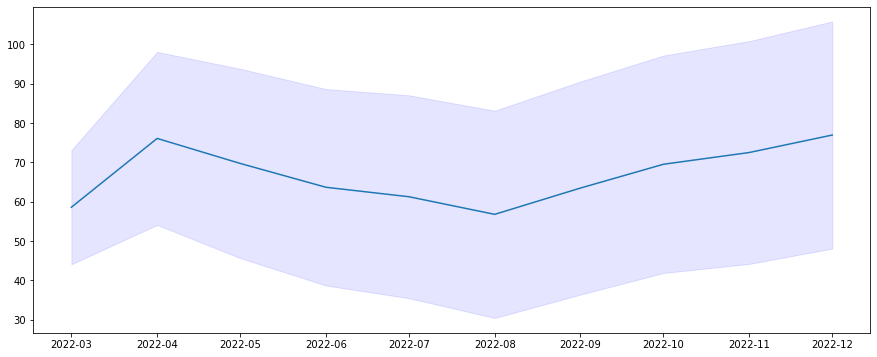

In [21]:
#Dibujo las resultados con intérvalo de confianza
plt.rcParams['figure.figsize']=(15,6)
ds=y_pred_media.reset_index()
#data
x = ds['index']
y = ds['predicted_mean']
#confidence interval
ci_low=intervalos['lower Plantilla_de_baja']
ci_upp=intervalos['upper Plantilla_de_baja']
fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, ci_low, ci_upp, color='b', alpha=.1)

In [22]:
y_pred_media

2022-03-01    58.599020
2022-04-01    76.079374
2022-05-01    69.729587
2022-06-01    63.673689
2022-07-01    61.267036
2022-08-01    56.797375
2022-09-01    63.475860
2022-10-01    69.519614
2022-11-01    72.501601
2022-12-01    76.939839
Freq: MS, Name: predicted_mean, dtype: float64

In [23]:
intervalos

,lower Plantilla_de_baja,upper Plantilla_de_baja
2022-03-01,44.118609,73.079431
2022-04-01,54.110048,98.048701
2022-05-01,45.691846,93.767328
2022-06-01,38.727692,88.619686
2022-07-01,35.500880,87.033192
2022-08-01,30.478301,83.116449
2022-09-01,36.417272,90.534448
2022-10-01,41.906350,97.132877
2022-11-01,44.209086,100.794116
2022-12-01,48.097826,105.781853


## Obtener coste medio mensual por sustitución enfermera/o

In [24]:
#Valor de tabla retributiva 2022 para DUI de nivel 2:
coste_mensual_bruto=1071.06+528.7+620.91+(781.15+528.7+620.91)/6
#No se tiene en cuenta importes de antiguedad como la carrera profesional y triennios ni atención continuada

In [25]:
coste_mensual_bruto

2542.463333333333

In [26]:
inf=y_pred_media.to_frame(name='plantilla_it')

In [27]:
inf['coste_mensual']=inf*coste_mensual_bruto

In [28]:
inf

,plantilla_it,coste_mensual
2022-03-01,58.599020,148985.859939
2022-04-01,76.079374,193429.020073
2022-05-01,69.729587,177284.918339
2022-06-01,63.673689,161888.019655
2022-07-01,61.267036,155769.192416
2022-08-01,56.797375,144405.242935
2022-09-01,63.475860,161385.045883
2022-10-01,69.519614,176751.068705
2022-11-01,72.501601,184332.662529
2022-12-01,76.939839,195616.720623


## Calcular cobertura a partir de coste_medio_mensual, previsión de plantilla de baja y crédito presupuestario

In [29]:
inf_cobertura_total=inf['coste_mensual'].sum()

In [30]:
#Credito inicial en bolsa de substituciones/eventuales para Hospital Germans Trias i Pujol 2022:
Importe_inicial=7879362.4+7930089.1
Exceso_permitido=12777320.97
credito_habilitado_2022=Importe_inicial+Exceso_permitido

In [31]:
#Gasto acumulado en subtituciones/eventuales
#gasto_enero
#gasto_febrero
gasto_en_substituciones_event_acum=4194367.95

In [32]:
credito_disponible=credito_habilitado_2022-gasto_en_substituciones_event_acum

In [33]:
credito_disponible_su=credito_disponible*0.5 
#el resto va para programas (25%), cobertura vacaciones (13%) y refuerzos (12%)

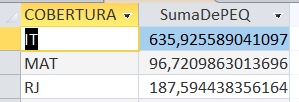

In [34]:
credito_disponible_su_it=credito_disponible_su*0.69
#el resto va para sustituciones de bajas maternales (10%) y reducciones de jornadas (21%)

In [35]:
credito_disponible_su_it_enfermeras=credito_disponible_su_it*0.36
#El 36% porque es la propoción media de personal enfermero de baja en el histórico

In [36]:
Cobertura_permitida=credito_disponible_su_it_enfermeras/inf_cobertura_total
Cobertura_permitida

1.7822399914507805

In [37]:
f'Con el crédito disponible de {credito_disponible_su_it_enfermeras:3,.2f} € se pueden cubrir el {Cobertura_permitida:.0%} de las bajas por IT previstas hasta final de año'

'Con el crédito disponible de 3,029,536.64 € se pueden cubrir el 178% de las bajas por IT previstas hasta final de año'

In [38]:
#formula para saber la ampliación o reducción de crédito necesária para cubrir X% de bajas
def estado_credito_SU(cobertura_deseada):
    '''cobretura expresada en %'''
    credito_necesario=inf_cobertura_total*cobertura_deseada/100
    saldo=credito_disponible_su_it_enfermeras-credito_necesario
    if saldo>0:
        return f'Se estima que sobrará {saldo:3,.2f} € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'
    else:
        return f'Se estima que faltará {-saldo:3,.2f} € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'


In [39]:
estado_credito_SU(100)

'Se estima que sobrará 1,329,688.89 € en la bolsa de substituciones en IT para el colectivo de enfermeras a final de año.'